In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import main_constants as ct
import json
from services.index import Index
import unidecode
from tqdm import tqdm
from retrieval.feature_extractors.EntityExtractor import EntityExtractor
import torch
from services import sql
import sqlite3
import collections as cl
import json
from tqdm import tqdm
import pickle
import pandas as pd
import spacy
import numpy as np
import torch
import seaborn as sns; sns.set()
from torch.utils.data import DataLoader
from retrieval.neural.dataset import QueryDocumentsDataset
from retrieval.neural.modules import encoders, scorers, rankers
from services.tsne import tsne

In [3]:
dev_data_set = QueryDocumentsDataset(ct.DEV_FEATURES_DB)
dev_loader = DataLoader(dev_data_set, batch_size=1, collate_fn=QueryDocumentsDataset.collate, shuffle=False)

INFO:root:[2018-12-28 14:28:06.182972]	[2153]	Initialized full dataset in 0:00:27.903426


Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 200...
Mean value of sigma: 1.644999
Iteration 10: error is 14.444075
Iteration 20: error is 13.884474
Iteration 30: error is 14.590270
Iteration 40: error is 14.321076
Iteration 50: error is 14.384102
Iteration 60: error is 14.411739
Iteration 70: error is 14.497240
Iteration 80: error is 14.436198
Iteration 90: error is 14.273240
Iteration 100: error is 15.060738
Iteration 110: error is 2.310687
Iteration 120: error is 1.823944
Iteration 130: error is 1.560817
Iteration 140: error is 1.411464
Iteration 150: error is 1.329000
Iteration 160: error is 1.235618
Iteration 170: error is 1.120258
Iteration 180: error is 1.037374
Iteration 190: error is 0.980890
Iteration 200: error is 0.927551
Iteration 210: error is 0.892057
Iteration 220: error is 0.853044
Iteration 230: error is 0.816551
Iteration 240: error is 0.800963
Iteration 250: error is 0.777358
Iteration 260: error is 0.752360
It

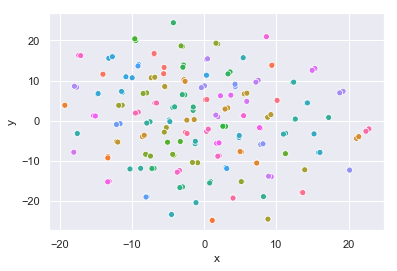

In [12]:
query_encoder = encoders.MaxPoolEncoder(50)
document_encoder = encoders.MaxPoolEncoder(50)
scorer = scorers.FullLinearLogisticRegression(120)
model = rankers.Pointwise(query_encoder, document_encoder, scorer)
with open('./models/max_pool_llr_full_pw/checkpoint_best.pt', 'rb') as file:
    checkpoint = torch.load(file, map_location=ct.DEVICE)
model.load_state_dict(checkpoint['model'])
model.eval()
examples = []

with torch.no_grad():
    for i, example in enumerate(dev_loader):
        if (i+1) > 100000:
            break
        query, document, features, target, question_id, doc_id = example
        if target == 1:
            energy, encoding = model(query, document, features)
            examples.append((torch.cat(encoding, dim=1).numpy(), question_id[0], target.numpy()))
encodings = np.empty((200, 120))
for i, (encoding, _id, target) in enumerate(examples):
    encodings[i] = encoding
projection = tsne(encodings, 2, 120)
data = pd.DataFrame(data=projection, columns=['x', 'y'])
questions = []
for i, row in enumerate(data['x']):
    questions.append(examples[i][1]) 
data['q'] = questions
data.head()
plot = sns.scatterplot(x='x', y='y', hue='q', data=data, legend=False)
fig = plot.get_figure()
fig.savefig("figures/combined.png", dpi=240)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 200...
Mean value of sigma: 1.568629
Iteration 10: error is 13.983358
Iteration 20: error is 13.760874
Iteration 30: error is 14.195287
Iteration 40: error is 14.424995
Iteration 50: error is 15.013811
Iteration 60: error is 15.448868
Iteration 70: error is 15.201161
Iteration 80: error is 15.923541
Iteration 90: error is 15.436512
Iteration 100: error is 15.920374
Iteration 110: error is 2.345955
Iteration 120: error is 1.851132
Iteration 130: error is 1.598734
Iteration 140: error is 1.424910
Iteration 150: error is 1.308591
Iteration 160: error is 1.231663
Iteration 170: error is 1.176598
Iteration 180: error is 1.123314
Iteration 190: error is 1.073341
Iteration 200: error is 1.041266
Iteration 210: error is 1.001544
Iteration 220: error is 0.962083
Iteration 230: error is 0.917566
Iteration 240: error is 0.861356
Iteration 250: error is 0.842258
Iteration 260: error is 0.833259
It

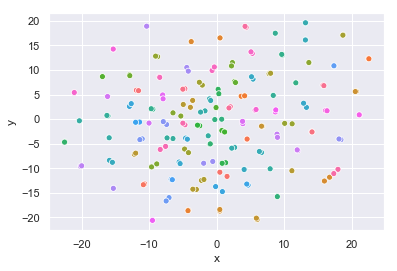

In [11]:
query_encoder = encoders.MaxPoolEncoder(50)
document_encoder = encoders.MaxPoolEncoder(50)
scorer = scorers.SemanticLinearLogisticRegression(100)
model = rankers.Pointwise(query_encoder, document_encoder, scorer)
with open('./models/max_pool_llr_embeddings_pw/checkpoint_best.pt', 'rb') as file:
    checkpoint = torch.load(file, map_location=ct.DEVICE)
model.load_state_dict(checkpoint['model'])
model.eval()
examples = []

with torch.no_grad():
    for i, example in enumerate(dev_loader):
        if (i+1) > 100000:
            break
        query, document, features, target, question_id, doc_id = example
        if target == 1:
            energy, encoding = model(query, document, features)
            examples.append((torch.cat(encoding[0:2], dim=1).numpy(), question_id[0], target.numpy()))
encodings = np.empty((200, 100))
for i, (encoding, _id, target) in enumerate(examples):
    encodings[i] = encoding
projection = tsne(encodings, 2, 100)
data = pd.DataFrame(data=projection, columns=['x', 'y'])
questions = []
for i, row in enumerate(data['x']):
    questions.append(examples[i][1]) 
data['q'] = questions
data.head()
sns.scatterplot(x='x', y='y', hue='q', data=data, legend=False)
fig = plot.get_figure()
fig.savefig("figures/embeddings.png", dpi=240)

In [13]:
query_encoder = encoders.MaxPoolEncoder(50)
document_encoder = encoders.MaxPoolEncoder(50)
scorer = scorers.FullLinearLogisticRegression(120)
model = rankers.Pointwise(query_encoder, document_encoder, scorer)
with open('./models/max_pool_llr_full_pw/checkpoint_best.pt', 'rb') as file:
    checkpoint = torch.load(file, map_location=ct.DEVICE)
model.load_state_dict(checkpoint['model'])

In [51]:
scorer_weights = model.scorer.linear.weight.detach().numpy().reshape(120, 1)
data = pd.DataFrame(np.abs(scorer_weights), columns=['y'])
data['x'] = range(0,120)
data['group'] = ''
data.loc[0:50, 'group'] = 'document encoding'
data.loc[50:100, 'group'] = 'query encoding'
data.loc[100:101, 'group'] = 'tf-idf'
data.loc[100:101, 'group'] = 'tf-idf'
data.loc[101:105, 'group'] = 'entity fuzzy match'
data.loc[105:107, 'group'] = 'translation model'
data.loc[107:109, 'group'] = 'bigram count'
data.loc[109:119, 'group'] = 'question word'
data.loc[119:120, 'group'] = 'document length'
data = data.reindex(columns=['x','y','group'])
data.head()

,x,y,group
0,0,0.502071,document encoding
1,1,0.565395,document encoding
2,2,0.491363,document encoding
3,3,0.499102,document encoding
4,4,0.717522,document encoding


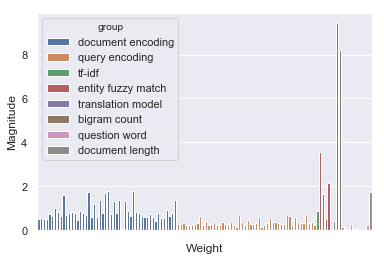

In [55]:
bp = sns.barplot(x='x', y='y', hue='group', data=data, dodge=False)
bp.set(xticklabels=[], xlabel='Weight', ylabel='Magnitude')
fig = bp.get_figure()
fig.savefig('figures/weights.png', dpi=240)